<a href="https://www.kaggle.com/code/jvinarek/czech-pastries-classifier?scriptVersionId=122640705" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# About

The notebook contains Czech pastries classifier. It is based on the fast ai course notebook https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

# Download images

In [52]:
!pip install -Uqq fastai duckduckgo_search

In [53]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [54]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('houska pečivo', max_images=1)
urls[0]

Searching for 'houska pečivo'


'https://eshop.rancherskespeciality.cz/fotky101916/fotos/P_11802_1.JPG'

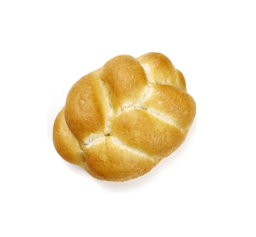

In [55]:
from fastdownload import download_url
dest = 'houska.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'rohlík'


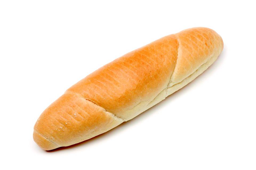

In [56]:
download_url(search_images('rohlík', max_images=1)[0], 'rohlik.jpg', show_progress=False)
Image.open('rohlik.jpg').to_thumb(256,256)

Searching for 'chléb'


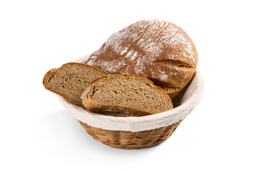

In [57]:
download_url(search_images('chléb', max_images=1)[0], 'chleba.jpg', show_progress=False)
Image.open('chleba.jpg').to_thumb(256,256)

Searching for 'koláč'


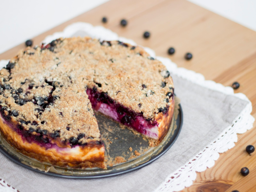

In [58]:
download_url(search_images('koláč', max_images=1)[0], 'kolac.jpg', show_progress=False)
Image.open('kolac.jpg').to_thumb(256,256)

Searching for 'šáteček pečivo'


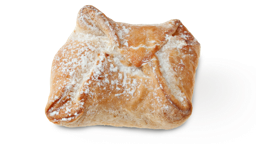

In [59]:
download_url(search_images('šáteček pečivo', max_images=1)[0], 'satecek.jpg', show_progress=False)
Image.open('satecek.jpg').to_thumb(256,256)

Searching for 'vánočka'


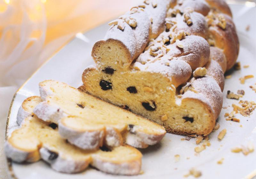

In [60]:
download_url(search_images('vánočka', max_images=1)[0], 'vanocka.jpg', show_progress=False)
Image.open('vanocka.jpg').to_thumb(256,256)

In [61]:
searches = 'houska pečivo', 'rohlík', 'chléb', 'koláč', 'šáteček pečivo', 'vánočka'
path = Path('pastry_classifier')
from time import sleep
from unidecode import unidecode

for search in searches:
    o = unidecode(search).split()[0]
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(search, max_images=200))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'houska pečivo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'rohlík'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'chléb'
Searching for 'koláč'
Searching for 'šáteček pečivo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'vánočka'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [62]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

# Train model

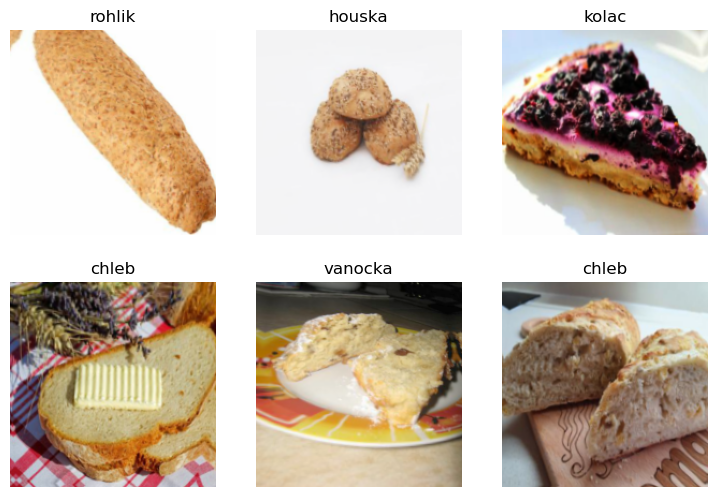

In [63]:
pastry = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms(),
)

dls = pastry.dataloaders(path, bs=32)

dls.show_batch(max_n=6)

## Data augmentation

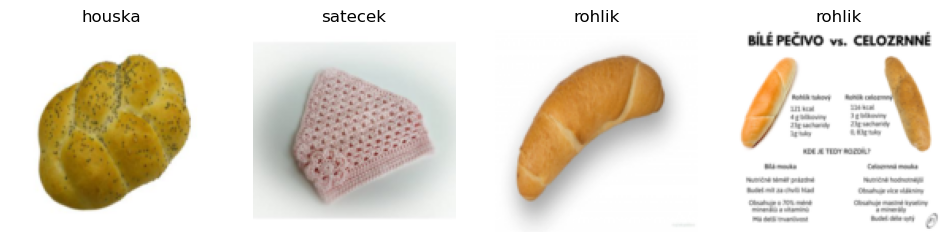

In [64]:
(
    pastry.new(item_tfms=Resize(128, ResizeMethod.Squish))
    .dataloaders(path).valid.show_batch(max_n=4, nrows=1)
)

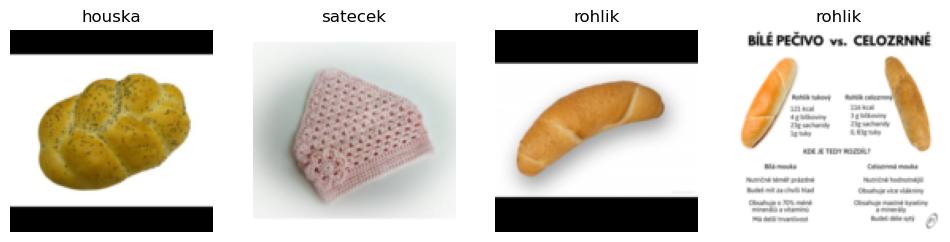

In [65]:
(
    pastry.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
    .dataloaders(path).valid.show_batch(max_n=4, nrows=1)
)

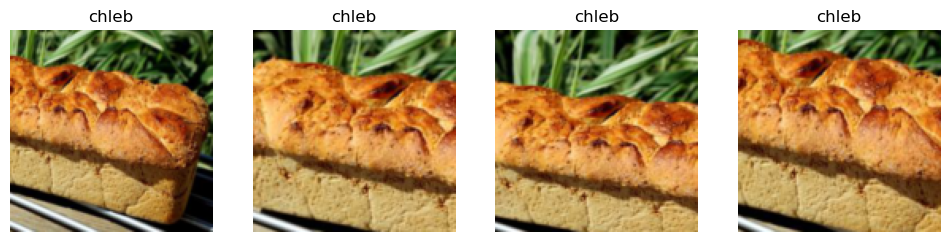

In [66]:
(
    pastry.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
    .dataloaders(path).train.show_batch(max_n=4, nrows=1, unique=True)
)

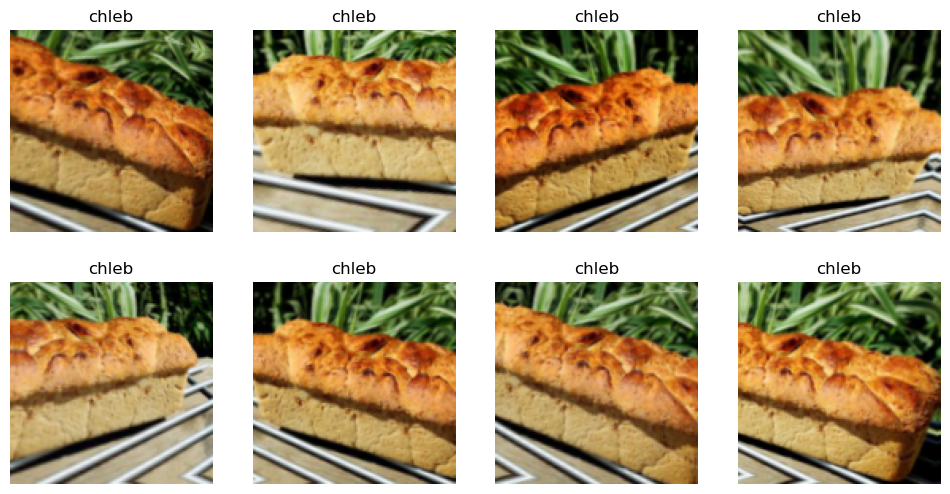

In [67]:
(
    pastry.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
    .dataloaders(path).train.show_batch(max_n=8, nrows=2, unique=True)
)

## Model fine tuning

In [78]:
dls = pastry.dataloaders(path, bs=32)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.871159,0.836980,0.265116,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.006590,0.489971,0.158140,00:13
1,0.713195,0.274067,0.090698,00:13
2,0.493641,0.217445,0.074419,00:13
3,0.338271,0.195537,0.062791,00:13


In [69]:
# learn.export('model.pkl')

In [70]:
pastry_kind,_,probs = learn.predict('rohlik.jpg')
print(f"This is a: {pastry_kind}.")

categories = learn.dls.vocab
print(dict(zip(categories, map(float, probs))))

This is a: rohlik.
{'chleb': 1.7327421346635674e-06, 'houska': 9.318164018168318e-08, 'kolac': 2.850199853909885e-09, 'rohlik': 0.9999979734420776, 'satecek': 2.3756945211061975e-07, 'vanocka': 1.2951870687061273e-08}


## Data cleaning

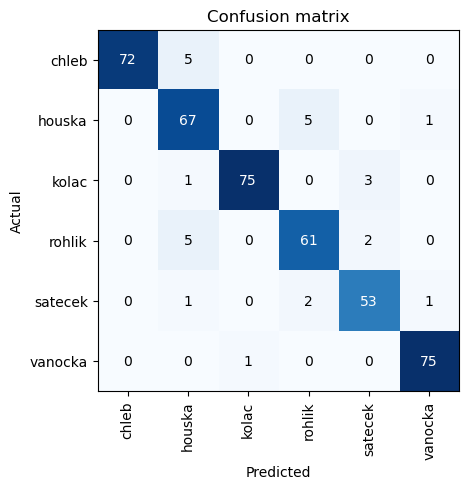

In [79]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

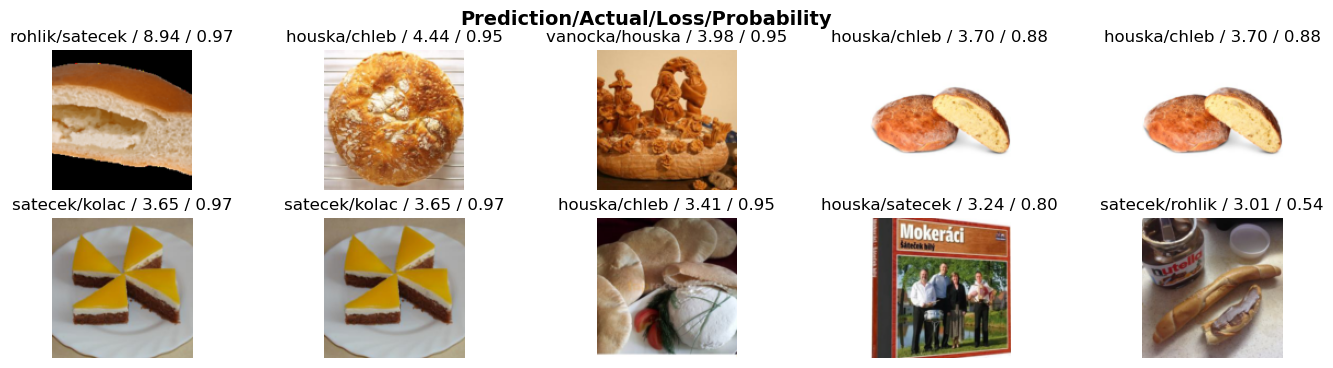

In [80]:
interp.plot_top_losses(10, nrows=2, figsize=(17,4))

In [82]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

In [83]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [85]:
dls = pastry.dataloaders(path, bs=32)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.874223,0.843761,0.241860,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.984917,0.596846,0.193023,00:14
1,0.798466,0.334750,0.102326,00:13
2,0.582442,0.261128,0.088372,00:14
3,0.445814,0.228490,0.081395,00:13
4,0.313432,0.207338,0.048837,00:14
5,0.231446,0.160837,0.037209,00:13
6,0.149747,0.139890,0.034884,00:13
7,0.126231,0.124711,0.034884,00:13
8,0.107361,0.124493,0.037209,00:13
9,0.096785,0.128482,0.037209,00:14


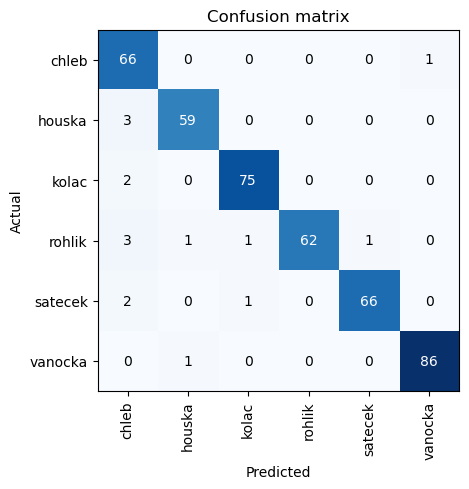

In [86]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Testing with uploaded data

In [87]:
import ipywidgets as widgets

# Create the widget
uploader = widgets.FileUpload(
    accept='.jpg',   # The type of files to accept
    multiple=False    # Whether to allow to upload multiple files or not
)

# Display the widget
display(uploader)

FileUpload(value={}, accept='.jpg', description='Upload')

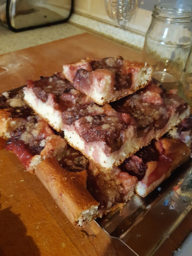

In [88]:
img = PILImage.create(uploader.data[0])
img.to_thumb(256,256)

In [89]:
img.save('upload_test.jpg')

In [91]:
pastry_kind,_,probs = learn.predict('upload_test.jpg')
print(f"This is a: {pastry_kind}.")

categories = learn.dls.vocab
print(dict(zip(categories, map(float, probs))))

This is a: kolac.
{'chleb': 0.0001875859743449837, 'houska': 1.1563836324057775e-06, 'kolac': 0.9791786670684814, 'rohlik': 1.7610501856779592e-07, 'satecek': 2.065167166165338e-07, 'vanocka': 0.020632058382034302}


# Export model

In [92]:
learn.export('model.pkl')